<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import iisignature
import sys
sys.path.append("../../")
from utils.addtime import AddTime, LeadLag
from importlib import reload
import utils.experiments as experiments
from sklearn.model_selection import StratifiedKFold
from importlib import reload
import utils.experiments as experiments 
import GP_models.GP_sig_precomputed as GP_sig
import utils.signature_features as signature_features
import esig.tosig as esig
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

In [9]:
def get_sig_keys(ndims, sig_level):
    keys = esig.sigkeys(ndims,sig_level).split("(")
    sig_keys = []

    for i in range(2,len(keys)-1):
        sig_keys.append(np.array(keys[i][:-2].split(',')))
    sig_keys.append(np.array(keys[len(keys)-1][:-1].split(',')))
    return sig_keys

In [10]:
def get_e_sig(bags):
    # signature spec
    level_sig = 4
    add_time_tf = AddTime()
    lead_lag_tf = LeadLag([0])

    expected_sigs = []

    for bag in bags:
        a = bag
#         a = add_time_tf.fit_transform(a)
#         a = np.array(a)
        a = lead_lag_tf.fit_transform(a)
        a = np.array(a)
        expected_sig = np.mean(iisignature.sig(a, level_sig), axis=0)
        expected_sigs.append(expected_sig)

    return expected_sigs

In [11]:
max_nb_items = 30
nb_folds = 3

# load the bags of time series
input_list = pickle.load(open('/Users/maudlemercier/Desktop/Distribution_Regression_Streams/data/crops/bags.obj', 'rb'))
y_ = pickle.load(open('/Users/maudlemercier/Desktop/Distribution_Regression_Streams/data/crops/labels.obj', 'rb'))

# cap the number of items in each bag (for memory constraints of baselines methods)
input_ = []
for i in range(len(input_list)):
    bag = input_list[i]
    nb = min(max_nb_items, len(bag))
    input_.append(bag[:nb])

In [12]:
# create folds
y = y_[:, 0]
bins = np.linspace(-0.1 + min(y), max(y) + 0.1, 20)
y_binned = np.digitize(y, bins)

train_indices_list = []
test_indices_list = []
skf = StratifiedKFold(n_splits=nb_folds, shuffle=True, random_state=0)
skf.get_n_splits(np.arange(len(y)), y_binned)
for train_index, test_index in skf.split(np.arange(len(y)), y_binned):
    train_indices_list.append(train_index)
    test_indices_list.append(test_index)

/Users/maudlemercier/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


In [13]:

def fit_ard(train_indices_list, test_indices_list, input_, y_):
    expected_sigs = get_e_sig(input_)

    lengthscales = []

    for fold in range(len(train_indices_list)):
        
#         train_indices = np.arange(220)
#         test_indices = np.arange(220,242)
        train_indices = train_indices_list[fold]
        test_indices = test_indices_list[fold]

        features = np.array(expected_sigs)[:, :]

        # Scale the (expected) signature features
        scaler = StandardScaler()
        to_fit = [features[i] for i in train_indices]
        scaler.fit(to_fit)
        features = scaler.transform(features)

        # Precompute the Gram matrix
        K_precomputed = experiments.precompute_K(features)

        rmse_train, r2_train, rmse_test, r2_test, l = experiments.experiment_ARD(features,y_,3,3,train_indices,test_indices,param_init=[0,50,0],RBF=True,plot=False,full=True)
        lengthscales.append(l)

    return lengthscales

In [14]:
reload(experiments)
lengthscales = fit_ard(train_indices_list, test_indices_list, input_, y_)

In [15]:

keys = get_sig_keys(3, 4)

#dico = {'1':'time','2':'nir','3':'red','4':'nir-lag'}#,'3':'red','4':'nir-lag'}
dico = {'1':'NIR','2':'Red','3':'NIR-lag'}

features_names = []
for i in range(len(keys)):
    separator = ','
    name = separator.join([dico[e] for e in keys[i]])
    features_names.append(str(i)+': '+'('+name+')')
print('number of features: ',len(features_names))

# fig, ax = plt.subplots(3,1,figsize=(20,15))
# axs = ax.ravel()
highest = []
dataframes = []
for i in range(3):
    l = pd.DataFrame([1./e for e in lengthscales[i][:100]],columns=[str(i)])
    l.index = features_names[:100]
    #l.plot(kind='bar',ax=axs[i],rot=90)
    dataframes.append(l)

# plt.tight_layout()
# plt.show()

number of features:  120


In [16]:
df = dataframes[0].join(dataframes[1]).join(dataframes[2])

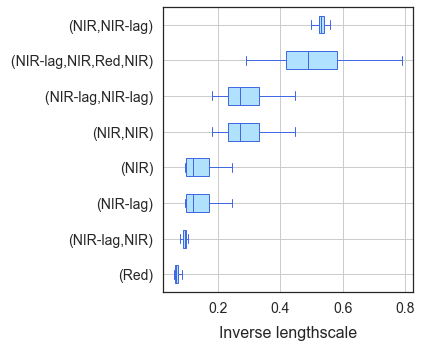

In [17]:
def remove_number(x):
    return x[3:]

sns.set(style="white")
fig,ax = plt.subplots(1,figsize=(6,5))
df['mean']=df.mean(axis=1)
df_sorted = df.sort_values(['mean'])
df_sorted.index = df_sorted.index.map(remove_number)
bplot = df_sorted.iloc[-8:].T.boxplot(vert=False,ax=ax,color='royalblue',grid=True,patch_artist=True,return_type='dict',fontsize=14)
colors = 8*['#B0E2FF']

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
plt.xlabel('Inverse lengthscale',fontsize=16,labelpad=10)
plt.tight_layout()
#plt.savefig('interpretability.pdf')
plt.show()